# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-mhx6UJW0-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 63356.60 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 95400.58 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 114556.84 examples/s]

Filter (num_proc=6):  66%|██████▌   | 74061/112120 [00:00<00:00, 108755.69 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 134758.45 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 72283.77 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 105814.13 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 124474.80 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 135907.99 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 148268.71 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 152491.98 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.30 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.99 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.33 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 51.55 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.74 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.61 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.41 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.01 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.22 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.91 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.00 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.05 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.47 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 39.97 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 44.56 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 47.57 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 46.47 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.24 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.05 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.01 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.32 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.45 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.17 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.06 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.82 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.75 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.43 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.40 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.89 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 16.86 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.63 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.02 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 40.28 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 43.92 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 43.18 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 42.90 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.23 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.32 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.87 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.03 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.16 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.20 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.63 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.61 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.05 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.25 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.10 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 37.03 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.47 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.14 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.49 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 41.94 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.50 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.03 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.41 examples/s]

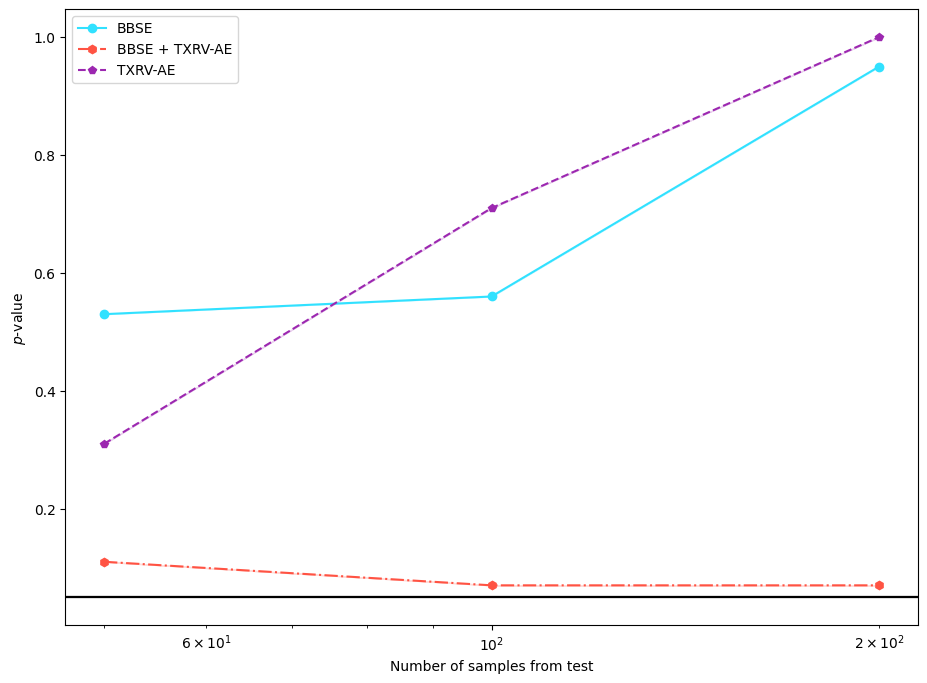

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.89 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.40 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.18 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.03 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.79 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.66 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.44 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.33 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.40 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.44 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.48 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 37.09 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.62 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.59 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.55 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.98 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.81 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.68 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.55 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.51 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.16 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.10 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.48 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.67 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.02 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.93 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.56 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.56 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.48 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.61 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.21 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.10 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.22 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.09 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.51 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.18 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.64 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.60 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.88 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.36 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.36 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.56 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.62 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.45 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.75 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.16 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.93 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.15 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.47 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.61 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.72 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.21 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.44 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.03 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.17 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.44 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.25 examples/s]

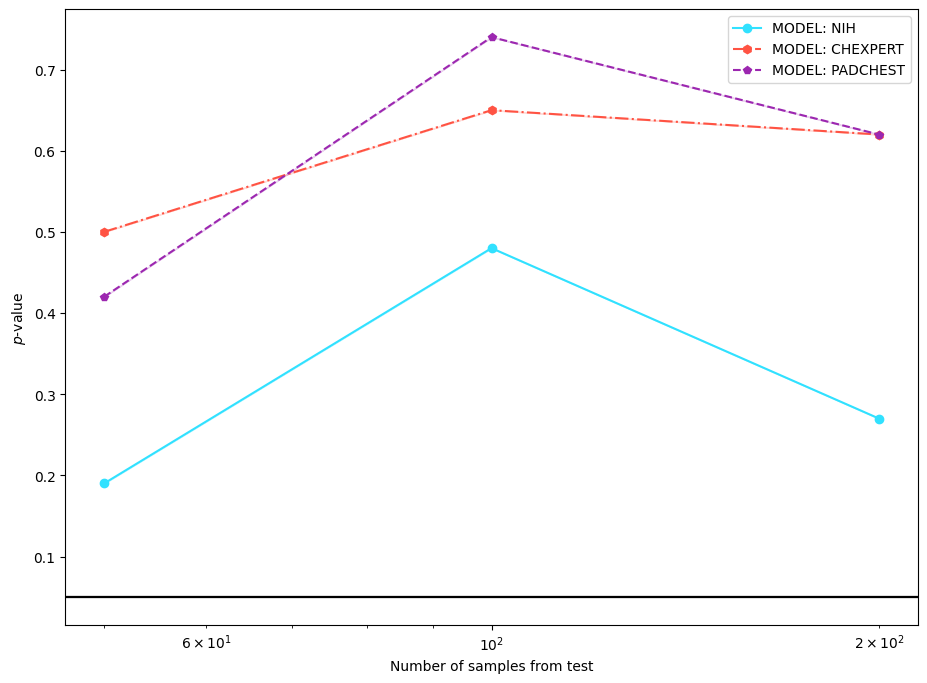

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54540.62 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 78983.44 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 95513.11 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98999.34 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106707.14 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 114260.01 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53540.17 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77043.72 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90769.74 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98899.57 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 102333.43 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 105362.63 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.09 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.49 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.23 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.69 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.26 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.88 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.34 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.84 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.79 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.83 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.34 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.90 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.56 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.06 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.93 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.90 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.31 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.00 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.56 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56455.49 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81881.29 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94362.88 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 101239.22 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 107893.89 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 113881.80 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56243.13 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81546.07 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 95131.31 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 103099.19 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 108606.18 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 112789.42 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.40 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.36 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.02 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.57 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.02 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.35 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.10 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.96 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.90 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.30 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.73 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.41 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.92 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.43 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.40 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.98 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.38 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.48 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 47800.01 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 74245.46 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90970.65 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97869.81 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 103956.46 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110621.00 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 46152.29 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 68435.96 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 78966.88 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 91232.62 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 106247.19 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 120765.48 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.13 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.50 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.30 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.47 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.39 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.73 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.51 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.27 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.78 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.17 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.87 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.61 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.54 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.36 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.12 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.70 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.60 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.97 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.72 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 50828.59 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72075.94 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 84924.54 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 90557.76 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 102627.20 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 113534.29 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 43818.12 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 69423.06 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 85681.00 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97315.28 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 104472.16 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109212.74 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.20 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.26 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.82 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.50 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.92 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.01 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.74 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.01 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.21 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.21 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.10 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.20 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.68 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.36 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.22 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.03 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.88 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.96 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.43 examples/s]

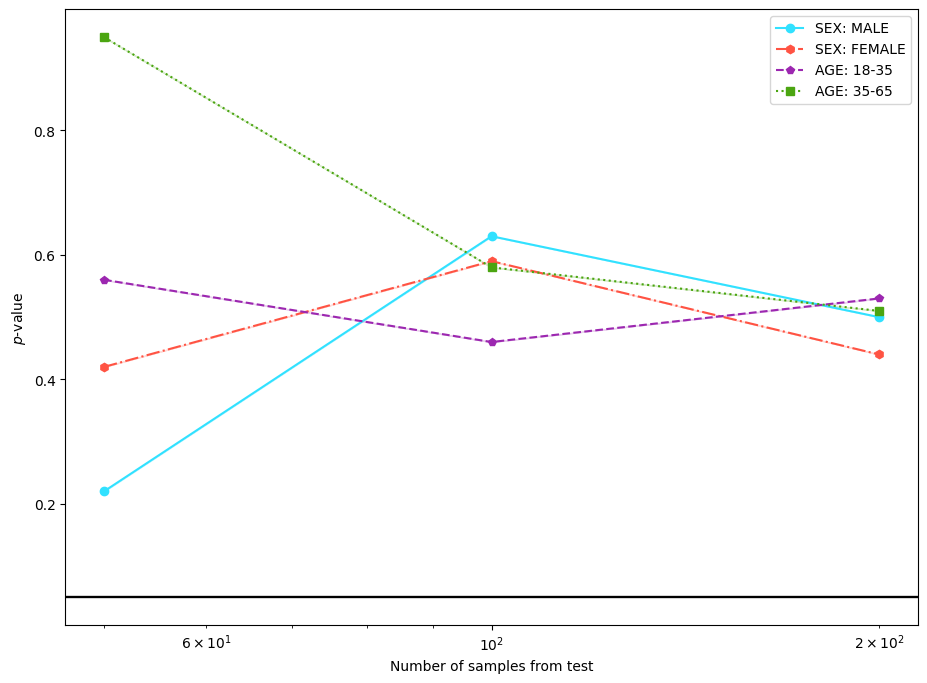

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.12 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.57 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.12 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.49 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.99 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.23 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.70 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.84 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.46 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.03 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.65 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.33 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.59 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.30 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.11 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.57 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.40 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.17 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.75 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.34 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.09 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.47 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.25 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.31 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.09 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.08 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.27 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.32 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.76 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.76 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.95 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.97 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.01 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.67 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.55 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.52 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.49 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.69 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.84 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.29 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.06 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.79 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.86 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.01 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.82 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.66 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.81 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.14 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.26 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.21 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.27 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.13 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.33 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.70 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.80 examples/s]

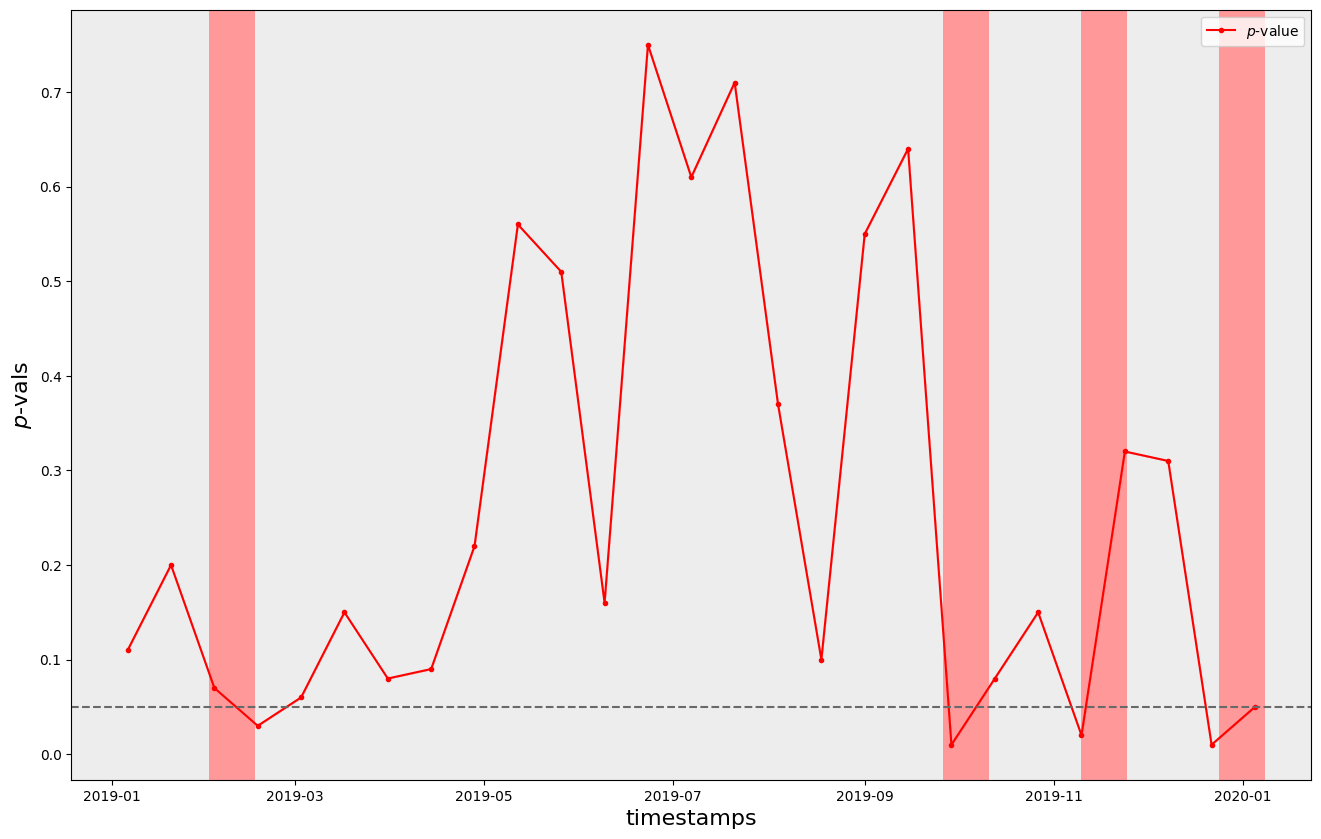

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)